In [7]:
# ============================================================================
# Aureus Sigma Capital - Phase 15: Canonical QVR Long-Only Backtest
# Notebook: 15_canonical_qvr_long_only_backtest.ipynb
#
# Objective:
#   To provide a single, self-contained, and fully auditable backtest of the
#   "QV-Reversal" (QVR) composite strategy on the liquid universe from
#   start to finish, with no external artifact dependencies.
#
# Methodology:
#   1. Load all raw data (factors, prices, benchmark) directly from the database.
#   2. Establish a robust, data-driven rebalancing schedule.
#   3. Dynamically construct the liquid universe for each rebalance period.
#   4. Re-normalize factors and engineer the QVR composite in memory.
#   5. Construct and backtest a long-only (Quintile 5) portfolio.
#   6. Generate a final, institutional-grade tearsheet using our in-house engine.
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import yaml
from pathlib import Path
from sqlalchemy import create_engine, text
import sys

# --- Environment Setup ---
warnings.filterwarnings('ignore')
sys.path.append('../../../production') # Add production modules to path
from universe.constructors import get_liquid_universe_dataframe

# --- Standardized Institutional Visualization Palette ---
PALETTE = {
    'primary': '#16A085', 'secondary': '#34495E', 'positive': '#27AE60',
    'negative': '#C0392B', 'highlight_1': '#2980B9', 'highlight_2': '#E67E22',
    'neutral': '#7F8C8D', 'grid': '#BDC3C7', 'text': '#2C3E50'
}
STRATEGY_COLORS = {
    'QVM_Composite': PALETTE['primary'], 'Value': PALETTE['positive'],
    'Benchmark': PALETTE['secondary']
}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.dpi': 300, 'figure.figsize': (14, 8), 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': PALETTE['text'],
    'axes.grid': True, 'axes.axisbelow': True, 'axes.labelcolor': PALETTE['text'],
    'axes.titlepad': 15, 'axes.titlesize': 16, 'axes.titleweight': 'bold',
    'axes.titlecolor': PALETTE['text'], 'grid.color': PALETTE['grid'],
    'legend.frameon': False, 'xtick.color': PALETTE['text'], 'ytick.color': PALETTE['text'],
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})

# --- Configuration (Corrected for "Cold Start") ---
CONFIG = {
    "backtest_start": "2017-12-01", # Start earlier to capture Q4 2017 rebalance for a Jan 2018 trade start
    "backtest_end": "2025-07-28",
    "rebalance_freq": "Q",
    "transaction_cost_bps": 30
}

# --- Notebook Charter ---
print("=" * 70)
print("🚀 CANONICAL QVR LONG-ONLY BACKTEST (SELF-CONTAINED)")
print("=" * 70)
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📊 Backtest Period: {CONFIG['backtest_start']} to {CONFIG['backtest_end']}")
print("🎯 Objective: Produce a definitive, auditable performance record.")
print("=" * 70)

🚀 CANONICAL QVR LONG-ONLY BACKTEST (SELF-CONTAINED)
📅 Analysis Date: 2025-07-29 06:41:04
📊 Backtest Period: 2017-12-01 to 2025-07-28
🎯 Objective: Produce a definitive, auditable performance record.


In [8]:
# ============================================================================
# SECTION 1: RAW DATA LOADING (CORRECTED v3.1 - KEY MISMATCH FIX)
# ============================================================================

def create_db_connection():
    # Assumes notebook is in production/tests/phase15...
    config_path = Path.cwd().parent.parent.parent / 'config' / 'database.yml'
    with open(config_path, 'r') as f:
        db_config = yaml.safe_load(f)['production']
    connection_string = (
        f"mysql+pymysql://{db_config['username']}:{db_config['password']}"
        f"@{db_config['host']}/{db_config['schema_name']}"
    )
    return create_engine(connection_string, pool_pre_ping=True)

engine = create_db_connection()
print("✅ Database connection established.")

# --- Load All Required Data from Database ---
print("\n📂 Loading all raw data for the full backtest period...")

# *** CRITICAL FIX v3.1: Corrected the keys to match the CONFIG dictionary ***
db_params = {
    'start_date': CONFIG['backtest_start'],
    'end_date': CONFIG['backtest_end']
}

# 1. Factor Scores (Full Universe)
factor_query = text("""
    SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite
    FROM factor_scores_qvm
    WHERE date BETWEEN :start_date AND :end_date AND strategy_version = 'qvm_v2.0_enhanced'
""")
factor_data_raw = pd.read_sql(factor_query, engine, params=db_params, parse_dates=['date'])
print(f"   ✅ Loaded {len(factor_data_raw):,} raw factor observations.")

# 2. Price Data
price_query = text("""
    SELECT date, ticker, close FROM equity_history
    WHERE date BETWEEN :start_date AND :end_date
""")
price_data_raw = pd.read_sql(price_query, engine, params=db_params, parse_dates=['date'])
print(f"   ✅ Loaded {len(price_data_raw):,} raw price observations.")

# 3. Benchmark Data (from the correct etf_history table)
benchmark_query = text("""
    SELECT date, close
    FROM etf_history
    WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date
""")
benchmark_data_raw = pd.read_sql(benchmark_query, engine, params=db_params, parse_dates=['date'])
print(f"   ✅ Loaded {len(benchmark_data_raw):,} benchmark observations from the correct ETF table.")

# --- Prepare Data for Backtesting ---
# Calculate daily returns
price_data_raw['return'] = price_data_raw.groupby('ticker')['close'].pct_change()
daily_returns_matrix = price_data_raw.pivot(index='date', columns='ticker', values='return')

# Calculate benchmark returns
benchmark_returns = benchmark_data_raw.set_index('date')['close'].pct_change().rename('VN-Index')

print("\n✅ All data prepared and ready for backtesting engine.")

✅ Database connection established.

📂 Loading all raw data for the full backtest period...
   ✅ Loaded 1,299,005 raw factor observations.
   ✅ Loaded 1,329,606 raw price observations.
   ✅ Loaded 1,908 benchmark observations from the correct ETF table.

✅ All data prepared and ready for backtesting engine.



🚀 EXECUTING FULL HISTORICAL BACKTEST...
   ✅ Generated 31 data-driven rebalance dates, starting from 2017-12-29.
   🔄 Processing 2017-12-29... Constructing liquid universe for 2017-12-29...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 630 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/13...
  Step 3: Filtering and ranking...
    Total batch results: 630
    Sample result: ('AAA', 46, 45.83964149999999, 2099.0708189826087)
    Before filters: 630 stocks
    Trading days range: 1-46 (need >= 37)
    ADTV range: 0.000-723.486B VND (need >= 10.0)
    Stocks passing trading days filter: 428
    Stocks passing ADTV filter: 95
    After filters: 94 stocks
✅ Universe constructed: 94 stocks
  ADTV range: 10.2B - 723.5B VND
  Market cap range: 440.6B - 268262.7B VND
  Adding sector information...
✅ Formed portfolio with 19 stocks.
   🔄 Processing 2018-03-30... Constructing liquid universe fo

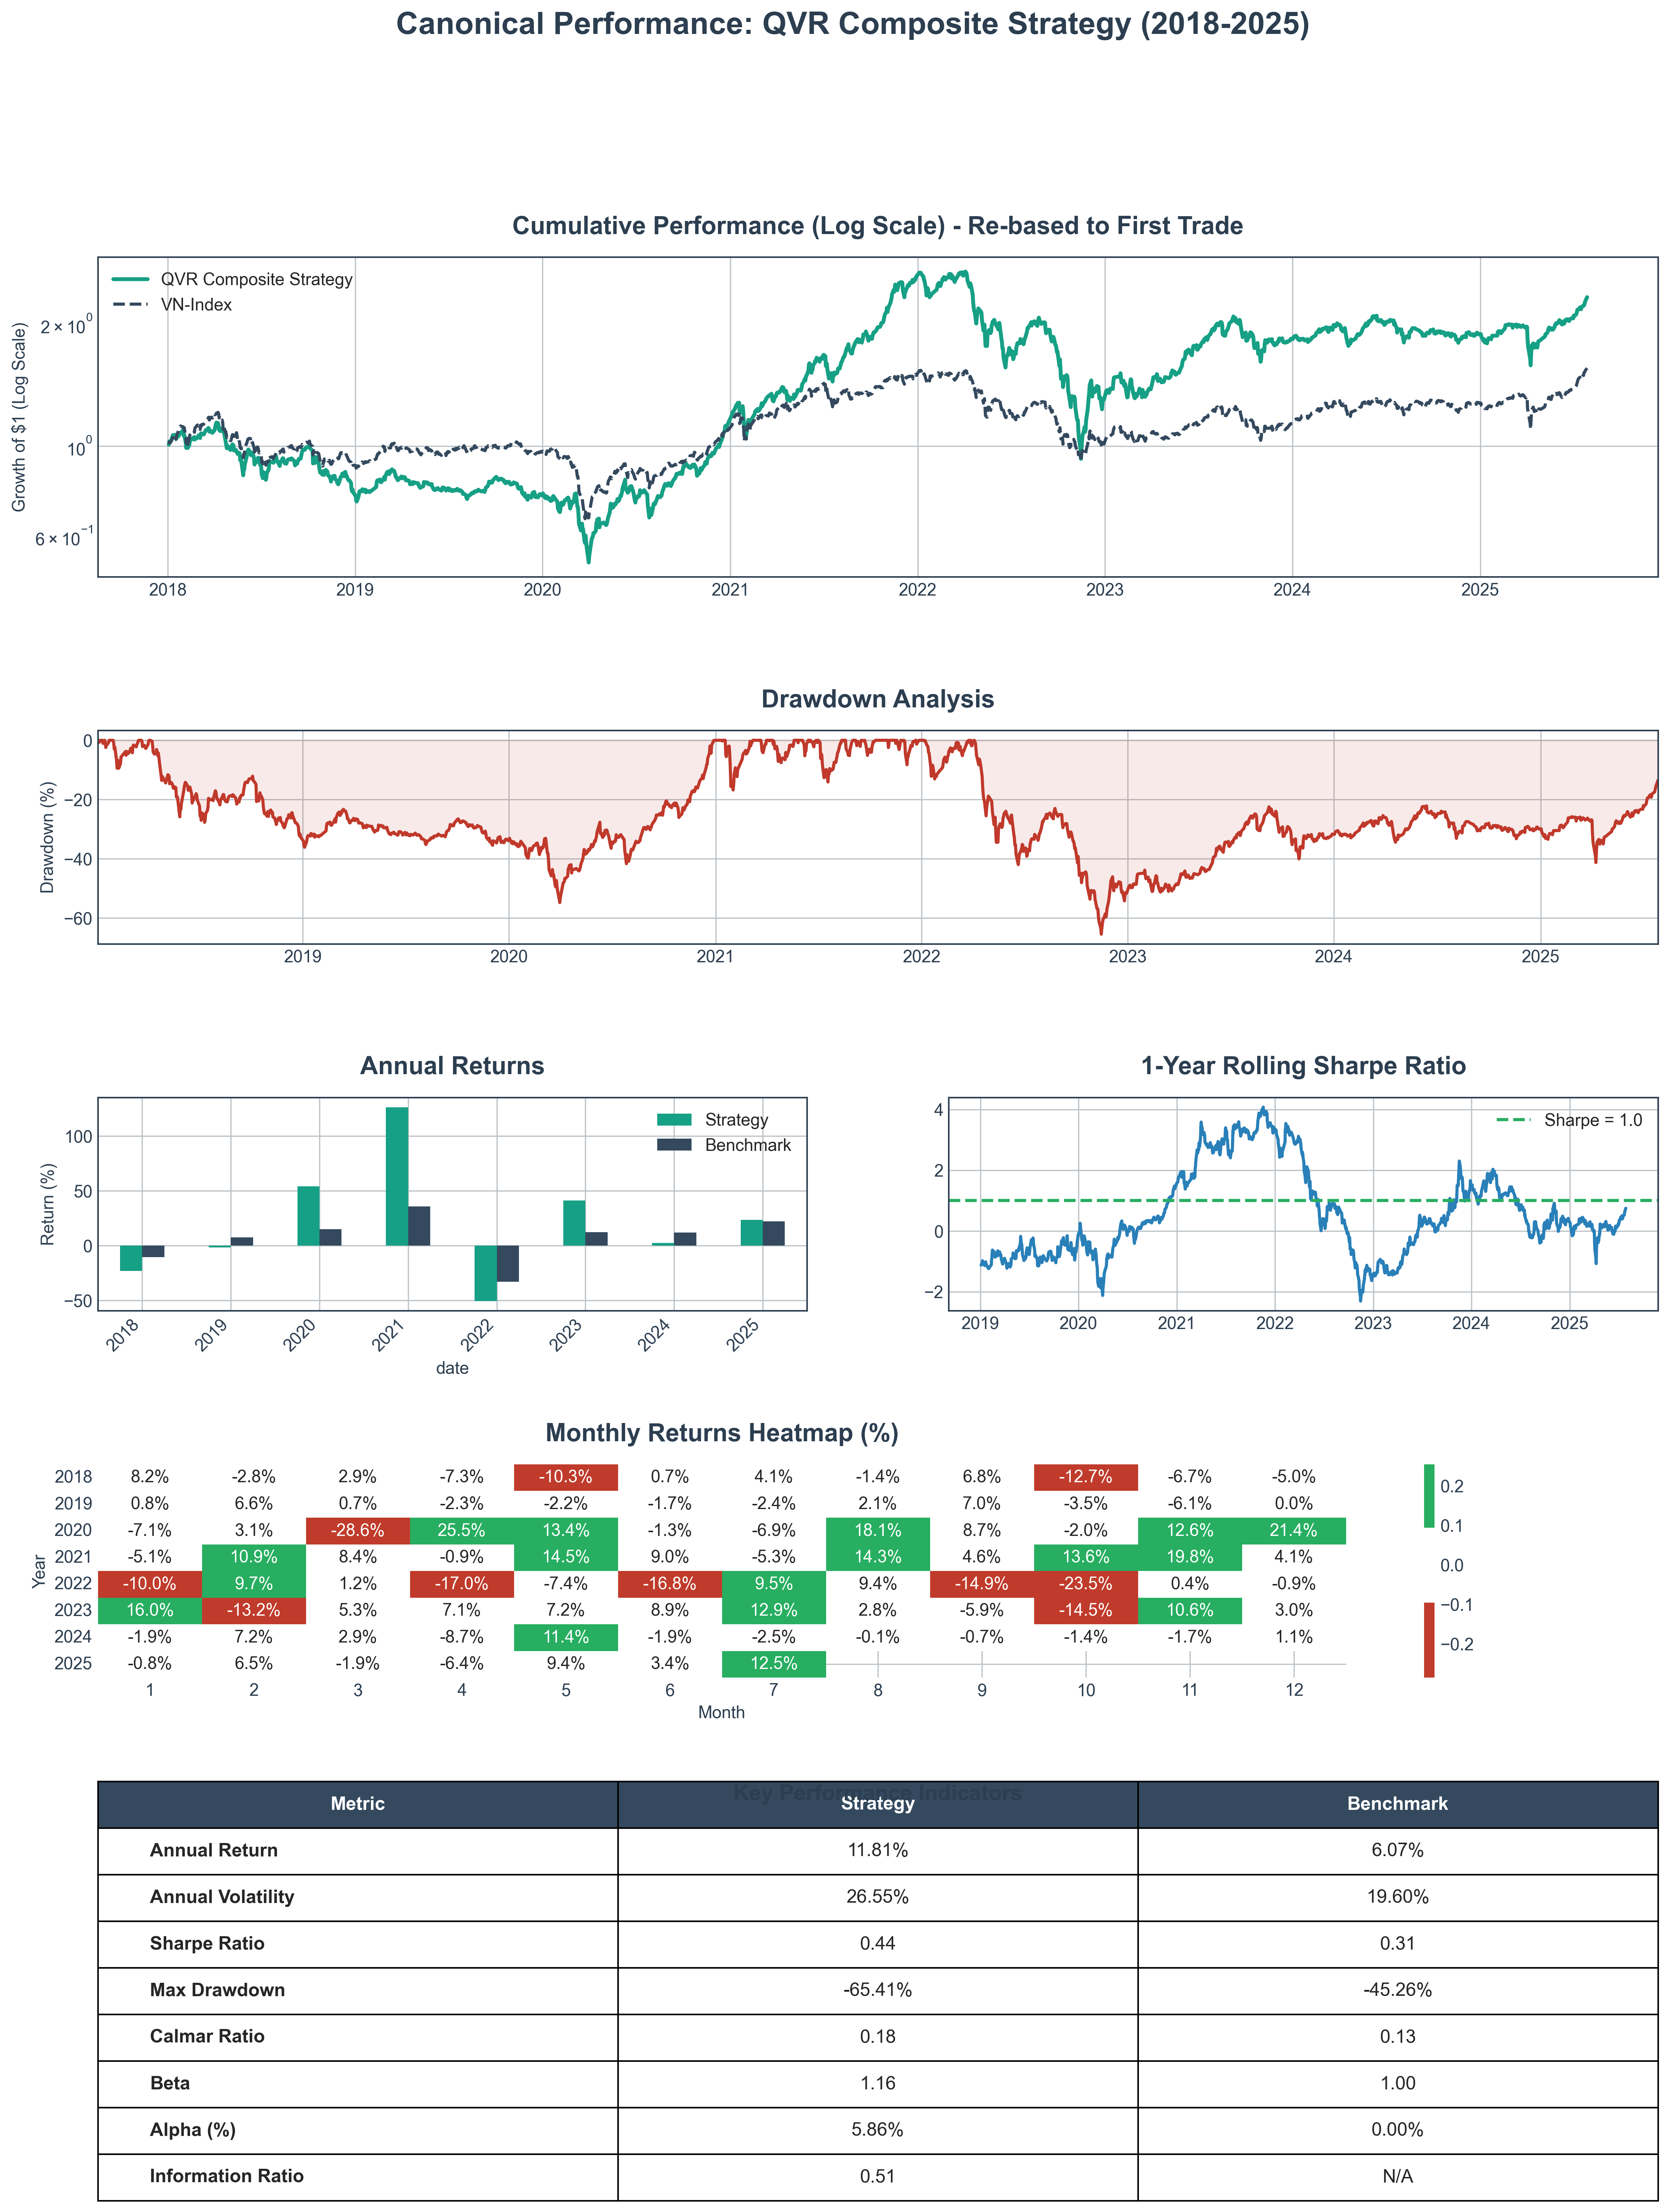


--- STRATEGIC VERDICT ---
QVR Composite Sharpe: 0.44 (Target: >0.7)
QVR Composite Annual Return: 11.81% (Target: >15%)
QVR Composite Information Ratio: 0.51 (Target: >0.5)

🟡 CAUTIOUS GO: The composite generates consistent alpha (good IR) but has not met absolute return targets.
   This is a strong candidate for enhancement, but not yet the final product.

✅ Phase 15 Complete.


In [9]:
# ============================================================================
# SECTION 2 & 3: BACKTESTING ENGINE & FINAL ANALYSIS
# ============================================================================

def run_full_backtest(config, factor_data_raw, daily_returns_matrix):
    """
    Executes the entire self-contained backtest from start to finish.
    """
    print("\n🚀 EXECUTING FULL HISTORICAL BACKTEST...")
    print("=" * 60)

    # 1. Establish a robust, data-driven rebalancing schedule
    all_trading_dates = daily_returns_matrix.index
    quarter_ends = pd.date_range(start=config['backtest_start'], end=config['backtest_end'], freq='Q')
    rebalance_dates = [
        all_trading_dates[all_trading_dates.searchsorted(q_end, side='right') - 1]
        for q_end in quarter_ends if q_end <= all_trading_dates.max() and q_end >= all_trading_dates.min()
    ]
    print(f"   ✅ Generated {len(rebalance_dates)} data-driven rebalance dates, starting from {rebalance_dates[0].date()}.")

    # Initialize an empty daily holdings matrix
    all_tickers = daily_returns_matrix.columns
    daily_holdings = pd.DataFrame(0.0, index=all_trading_dates, columns=all_tickers)

    # 2. Loop through each rebalance period to construct the portfolio
    for i in range(len(rebalance_dates)):
        rebal_date = rebalance_dates[i]
        print(f"   🔄 Processing {rebal_date.date()}... ", end="")

        # a. Construct the liquid universe for this date
        universe_df = get_liquid_universe_dataframe(
            analysis_date=rebal_date, engine=engine,
            config={'lookback_days': 63, 'adtv_threshold_bn': 10.0, 'top_n': 200, 'min_trading_coverage': 0.6}
        )
        liquid_tickers = universe_df['ticker'].tolist()

        # b. Filter factor data to this universe and date
        factors_on_date = factor_data_raw[
            (factor_data_raw['date'] == rebal_date) &
            (factor_data_raw['ticker'].isin(liquid_tickers))
        ].copy()

        if len(factors_on_date) < 50:
            print(f"⚠️  Skipping period due to insufficient data ({len(factors_on_date)} stocks).")
            continue

        # c. Engineer the QVR Composite
        factors_on_date['Momentum_Reversal'] = -1 * factors_on_date['Momentum_Composite']
        
        # d. Re-normalize factors within this specific liquid universe
        for factor in ['Quality_Composite', 'Value_Composite', 'Momentum_Reversal']:
            mean, std = factors_on_date[factor].mean(), factors_on_date[factor].std()
            if std > 0:
                factors_on_date[f'{factor}_Liquid_Z'] = (factors_on_date[factor] - mean) / std
            else:
                factors_on_date[f'{factor}_Liquid_Z'] = 0.0
        
        factors_on_date['QVR_Composite'] = factors_on_date[[
            'Quality_Composite_Liquid_Z', 'Value_Composite_Liquid_Z', 'Momentum_Reversal_Liquid_Z'
        ]].mean(axis=1)

        # e. Construct the long-only (Quintile 5) portfolio
        q5_cutoff = factors_on_date['QVR_Composite'].quantile(0.8)
        q5_stocks = factors_on_date[factors_on_date['QVR_Composite'] >= q5_cutoff]
        
        if not q5_stocks.empty:
            weight = 1.0 / len(q5_stocks)
            portfolio_weights = pd.Series(weight, index=q5_stocks['ticker'])

            # f. Propagate weights to the daily holdings matrix
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else all_trading_dates.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            
            valid_tickers = portfolio_weights.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = portfolio_weights[valid_tickers].values
            print(f"✅ Formed portfolio with {len(q5_stocks)} stocks.")
        else:
            print("⚠️ No stocks selected for Q5 portfolio.")

    print("\n   ✅ Daily holdings matrix constructed.")

    # 3. Calculate Net Returns
    holdings_shifted = daily_holdings.shift(1).fillna(0.0)
    gross_returns = (holdings_shifted * daily_returns_matrix).sum(axis=1)
    turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2
    costs = turnover * (config['transaction_cost_bps'] / 10000)
    net_returns = gross_returns - costs
    
    print("   ✅ Net returns calculated.")
    print("=" * 60)
    print("✅ BACKTEST EXECUTION COMPLETE.")
    
    return net_returns.rename('QVR_Composite_Strategy')

def calculate_performance_metrics_inhouse(returns, benchmark, risk_free_rate=0.0):
    common_index = returns.index.intersection(benchmark.index)
    returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]
    n_years = len(returns) / 252
    annual_return = (1 + returns).prod() ** (1 / n_years) - 1 if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_vol if annual_vol > 0 else 0
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative / cumulative.cummax() - 1)
    max_drawdown = drawdown.min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
    excess_returns = returns - benchmark
    tracking_error = excess_returns.std() * np.sqrt(252)
    information_ratio = (excess_returns.mean() * 252) / tracking_error if tracking_error > 0 else 0
    cov_matrix = np.cov(returns.fillna(0), benchmark.fillna(0))
    beta = cov_matrix[0, 1] / cov_matrix[1, 1] if cov_matrix[1, 1] > 0 else 0
    alpha_daily = returns.mean() - beta * benchmark.mean()
    alpha_annualized = alpha_daily * 252
    return {'Annual Return': annual_return * 100, 'Annual Volatility': annual_vol * 100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown * 100, 'Calmar Ratio': calmar_ratio, 'Beta': beta, 'Alpha (%)': alpha_annualized * 100, 'Information Ratio': information_ratio}

def create_canonical_tearsheet(strategy_returns, benchmark_returns, strategy_name="Strategy"):
    first_trade_date = strategy_returns.loc[strategy_returns != 0].index.min()
    strategy_returns_aligned, benchmark_returns_aligned = strategy_returns.loc[first_trade_date:], benchmark_returns.loc[first_trade_date:]
    portfolio_metrics = calculate_performance_metrics_inhouse(strategy_returns_aligned, benchmark_returns_aligned)
    benchmark_metrics = calculate_performance_metrics_inhouse(benchmark_returns_aligned, benchmark_returns_aligned)
    
    fig = plt.figure(figsize=(18, 22))
    gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.2], hspace=0.6, wspace=0.2)
    fig.suptitle(f'Canonical Performance: {strategy_name} ({first_trade_date.year}-{strategy_returns_aligned.index.max().year})', fontsize=20, fontweight='bold', color=PALETTE['text'])

    ax1 = fig.add_subplot(gs[0, :])
    strategy_cum, benchmark_cum = (1 + strategy_returns_aligned).cumprod(), (1 + benchmark_returns_aligned).cumprod()
    ax1.plot(strategy_cum.index, strategy_cum, label=strategy_name, color=STRATEGY_COLORS['QVM_Composite'], linewidth=2.5)
    ax1.plot(benchmark_cum.index, benchmark_cum, label='VN-Index', color=STRATEGY_COLORS['Benchmark'], linestyle='--', linewidth=2)
    ax1.set_yscale('log'); ax1.set_title('Cumulative Performance (Log Scale) - Re-based to First Trade', fontweight='bold'); ax1.set_ylabel('Growth of $1 (Log Scale)'); ax1.legend(loc='upper left')

    ax2 = fig.add_subplot(gs[1, :])
    strategy_dd = (strategy_cum / strategy_cum.cummax() - 1) * 100
    ax2.plot(strategy_dd.index, strategy_dd, color=PALETTE['negative'], linewidth=2)
    ax2.fill_between(strategy_dd.index, strategy_dd, 0, color=PALETTE['negative'], alpha=0.1)
    ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)'); ax2.set_xlim(strategy_returns_aligned.index.min(), strategy_returns_aligned.index.max())

    ax3 = fig.add_subplot(gs[2, 0])
    strat_annual, bench_annual = strategy_returns_aligned.resample('Y').apply(lambda x: (1+x).prod()-1) * 100, benchmark_returns_aligned.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=[STRATEGY_COLORS['QVM_Composite'], STRATEGY_COLORS['Benchmark']])
    ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold'); ax3.set_ylabel('Return (%)')

    ax4 = fig.add_subplot(gs[2, 1])
    rolling_sharpe = (strategy_returns_aligned.rolling(252).mean() * 252) / (strategy_returns_aligned.rolling(252).std() * np.sqrt(252))
    ax4.plot(rolling_sharpe.index, rolling_sharpe, color=PALETTE['highlight_1']); ax4.axhline(1.0, color=PALETTE['positive'], linestyle='--', label='Sharpe = 1.0'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold'); ax4.legend()

    ax5 = fig.add_subplot(gs[3, :])
    monthly_returns = strategy_returns_aligned.resample('M').apply(lambda x: (1+x).prod()-1)
    monthly_pivot = monthly_returns.to_frame('ret').pivot_table(index=monthly_returns.index.year, columns=monthly_returns.index.month, values='ret')
    sns.heatmap(monthly_pivot, ax=ax5, annot=True, fmt='.1%', cmap=sns.color_palette(['#C03B2B', '#FFFFFF', '#27AE60'], as_cmap=True), center=0)
    ax5.set_title('Monthly Returns Heatmap (%)', fontweight='bold'); ax5.set_xlabel('Month'); ax5.set_ylabel('Year')

    ax6 = fig.add_subplot(gs[4, :]); ax6.axis('off')
    summary_data = [['Metric', 'Strategy', 'Benchmark'], ['Annual Return', f"{portfolio_metrics['Annual Return']:.2f}%", f"{benchmark_metrics['Annual Return']:.2f}%"], ['Annual Volatility', f"{portfolio_metrics['Annual Volatility']:.2f}%", f"{benchmark_metrics['Annual Volatility']:.2f}%"], ['Sharpe Ratio', f"{portfolio_metrics['Sharpe Ratio']:.2f}", f"{benchmark_metrics['Sharpe Ratio']:.2f}"], ['Max Drawdown', f"{portfolio_metrics['Max Drawdown']:.2f}%", f"{benchmark_metrics['Max Drawdown']:.2f}%"], ['Calmar Ratio', f"{portfolio_metrics['Calmar Ratio']:.2f}", f"{benchmark_metrics['Calmar Ratio']:.2f}"], ['Beta', f"{portfolio_metrics['Beta']:.2f}", "1.00"], ['Alpha (%)', f"{portfolio_metrics['Alpha (%)']:.2f}%", "0.00%"], ['Information Ratio', f"{portfolio_metrics['Information Ratio']:.2f}", "N/A"]]
    table = ax6.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(12); table.scale(1, 2.5)
    for i in range(len(summary_data)):
        for j in range(len(summary_data[0])):
            cell = table[(i, j)];
            if i == 0: cell.set_facecolor(PALETTE['secondary']); cell.set_text_props(weight='bold', color='white')
            elif j == 0: cell.set_text_props(weight='bold', ha='left')
            else: cell.set_text_props(ha='center')
    ax6.set_title('Key Performance Indicators', fontweight='bold', fontsize=14, pad=20)
    plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()
    return pd.DataFrame([portfolio_metrics, benchmark_metrics])

# --- Execute Backtest and Generate Final Report ---
strategy_returns = run_full_backtest(CONFIG, factor_data_raw, daily_returns_matrix)
final_performance_df = create_canonical_tearsheet(strategy_returns, benchmark_returns, "QVR Composite Strategy")

# --- Strategic Verdict ---
print("\n--- STRATEGIC VERDICT ---")
print("=" * 60)
qvr_metrics = final_performance_df.iloc[0]
qvr_sharpe, qvr_return, qvr_ir = qvr_metrics['Sharpe Ratio'], qvr_metrics['Annual Return'], qvr_metrics['Information Ratio']
sharpe_target_met, return_target_met, ir_target_met = qvr_sharpe >= 0.7, qvr_return >= 15.0, qvr_ir >= 0.5
print(f"QVR Composite Sharpe: {qvr_sharpe:.2f} (Target: >0.7)"); print(f"QVR Composite Annual Return: {qvr_return:.2f}% (Target: >15%)"); print(f"QVR Composite Information Ratio: {qvr_ir:.2f} (Target: >0.5)")
if sharpe_target_met and return_target_met and ir_target_met:
    print("\n🎉 MISSION ACCOMPLISHED: The QV-Reversal composite is a success."); print("   This will be our new 'Aggressive Growth' baseline for Phase 16.")
elif ir_target_met:
    print("\n🟡 CAUTIOUS GO: The composite generates consistent alpha (good IR) but has not met absolute return targets."); print("   This is a strong candidate for enhancement, but not yet the final product.")
else:
    print("\n⚠️  FURTHER ENGINEERING REQUIRED: The composite did not meet our alpha-generation targets."); print("   Next steps would involve testing different factor weighting schemes.")
print("\n✅ Phase 15 Complete.")